##### For this I want to compare two shows Community and Arrested Development.  Specifically the first 3 season of each, looking at the ratings of each episode instead of the overall ratings.  In order to do this I will scrape IMDB of season, epsiode #, episode name, and rating for each show.
    - Community               tt1439629
    - Arrested Development    tt0367279
    
Code for scraping IMDB show edited from:
        https://towardsdatascience.com/scraping-tv-show-epsiode-imdb-ratings-using-python-beautifulsoup-7a9e09c4fbe5
    

In [1]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns

C:\Users\peter\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def IMDB(code, show, start, end):
    imdb_episodes = []
    #For selected seasons.  End must be larger than start.  ALso must add 1 becuase of pythons way of counting.
    for sn in range(start, end+1):
        # Request the server the content of the web page by using get(),
        # and store the server’s response in the variable response
        response = get('https://www.imdb.com/title/'+ str(code) + '/episodes?season='+ str(sn))

        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')

        # Select all the episode containers from the season page
        episode_containers = page_html.find_all('div', class_ = 'info')

        # For each episode in each season
        for episodes in episode_containers:
                # Get the info of each episode on the page
                season = sn
                episode_number = episodes.meta['content']
                title = episodes.a['title']
                airdate = episodes.find('div', class_='airdate').text.strip()
                rating = episodes.find('span', class_='ipl-rating-star__rating').text
                total_votes = episodes.find('span', class_='ipl-rating-star__total-votes').text
                desc = episodes.find('div', class_='item_description').text.strip()
                # Compiling the episode info
                episode_data = [season, episode_number, title, airdate, rating, total_votes, desc]

                # Append the episode info to the complete dataset
                imdb_episodes.append(episode_data)
    imdb_episodes = pd.DataFrame(imdb_episodes, columns = ['Season', 'episode_number', 'title',
                                                           'airdate', 'rating', 'total_votes', 'desc'])
    imdb_episodes[["episode_number"]] = imdb_episodes[["episode_number"]].apply(pd.to_numeric)
    def remove_str(votes):
        for r in ((',',''), ('(',''),(')','')):
            votes = votes.replace(*r)
        return votes

    imdb_episodes['total_votes'] = imdb_episodes.total_votes.apply(remove_str).astype(int)
    imdb_episodes['rating'] = imdb_episodes.rating.astype(float)
    imdb_episodes['airdate'] = pd.to_datetime(imdb_episodes.airdate)
    imdb_episodes['weightavg'] = imdb_episodes.rating*imdb_episodes.total_votes
    
    print("Analysis for ", show, "seasons", start, "-", (end))
    print("IMDB code:", code)
    Med = round(imdb_episodes.rating.median(),2)
    Avg = round(imdb_episodes.rating.mean(),2)
    WAvg = round(imdb_episodes.weightavg.sum()/imdb_episodes.total_votes.sum(),2)
    TVotes = imdb_episodes.total_votes.sum()
    print("Median rating: ", Med)
    print("Average rating:  ", Avg)
    print("Number of episodes:  ",len(imdb_episodes))
    print("Weighted average rating:  ", WAvg)
    print("Total number of votes: ", f'{TVotes:,}')   
    print("")
    print('\033[1m' + "Highest rated episode:" + \
          '\033[0m', imdb_episodes.title.iloc[imdb_episodes['rating'].idxmax()],
          ", Season", imdb_episodes.Season.iloc[imdb_episodes['rating'].idxmax()],
          " episode ", imdb_episodes.episode_number.iloc[imdb_episodes['rating'].idxmax()],
          " [", imdb_episodes['rating'].max(), "]")
          
    print('\033[1m' + "Lowest rated episode:" + \
          '\033[0m', imdb_episodes.title.iloc[imdb_episodes['rating'].idxmin()],
          ", Season", imdb_episodes.Season.iloc[imdb_episodes['rating'].idxmin()],
          " episode ", imdb_episodes.episode_number.iloc[imdb_episodes['rating'].idxmin()],
          " [", imdb_episodes['rating'].min(), "]")
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(6,4))
    
    #plt.xticks([0], ['Overall'])
    ax.set_title('Overall', fontsize=10) #, fontweight='bold'
    ax.yaxis.set_label_text('Rating')
    ax = imdb_episodes.boxplot(column=['rating'], ax=ax)
    ax.set_ylim(5.5, 10)
    ax.set_xticks([])
    
    ax2 = imdb_episodes.boxplot(by='Season',column=['rating'], ax=ax2)
    ax2.set_title('Rating by Season', fontsize=10)#, fontweight='bold')
    ax2.set_ylim(5.5, 10)
    ax2.yaxis.set_label_text('')#Rating')
    fig.suptitle(show, fontsize=12, fontweight='bold', y=1) #'' + show + ''
    
    fig2, ax3 = plt.subplots(figsize=(6, 4))
    fig2.suptitle('')    
    ax3.plot(imdb_episodes['rating'], imdb_episodes['total_votes'], 'ro')
    ax3.set_title(show + ', rating by Votes per episode', fontsize=12, fontweight='bold')
    ax3.xaxis.set_label_text('Episode Rating')
    ax3.yaxis.set_label_text('Votes per Episode')
    
    heatmap = imdb_episodes.pivot("episode_number", "Season", "rating")
    ax4 = plt.subplots(figsize=(10,10)) 
    ax4 = sns.heatmap(heatmap, annot=True, cmap="coolwarm", square=True, vmin=5, vmax=10, cbar=False)
    bottom, top = ax4.get_ylim()
    ax4.set_ylim(bottom + 0.5, top - 0.5)
    plt.tick_params(axis='both', which='major', labelsize=10, bottom=False, labeltop=True, labelbottom =False)
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.set_title(show + ' heatmap', fontsize=12, fontweight='bold')
    

    return imdb_episodes

Analysis for  Community seasons 1 - 6
IMDB code: tt1439629
Median rating:  8.2
Average rating:   8.32
Number of episodes:   110
Weighted average rating:   8.5
Total number of votes:  302,265

Highest rated episode: Modern Warfare , Season 1  episode  23  [ 9.8 ]
Lowest rated episode: Economics of Marine Biology , Season 4  episode  7  [ 6.7 ]


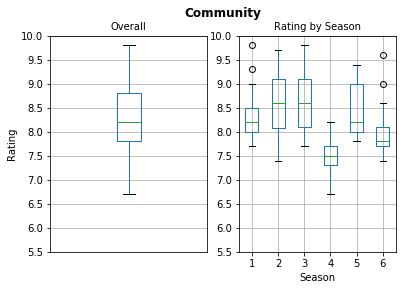

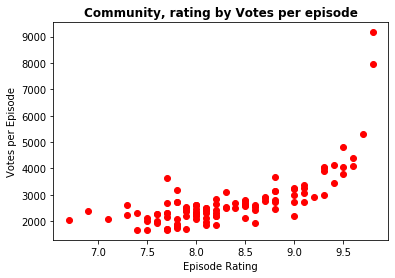

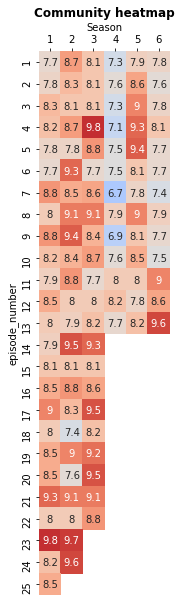

In [3]:
df1 = IMDB('tt1439629', 'Community', 1, 6)

Analysis for  Arrested Development seasons 1 - 5
IMDB code: tt0367279
Median rating:  8.3
Average rating:   8.22
Number of episodes:   84
Weighted average rating:   8.37
Total number of votes:  127,950

Highest rated episode: Development Arrested , Season 3  episode  13  [ 9.3 ]
Lowest rated episode: Saving for Arraignment Day , Season 5  episode  14  [ 6.8 ]


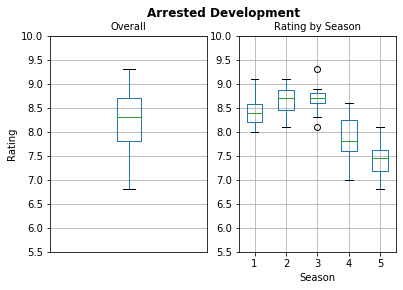

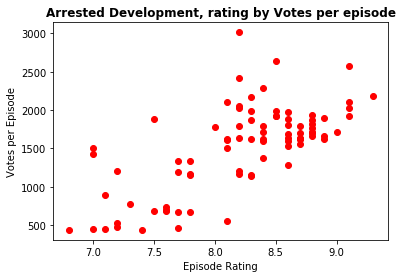

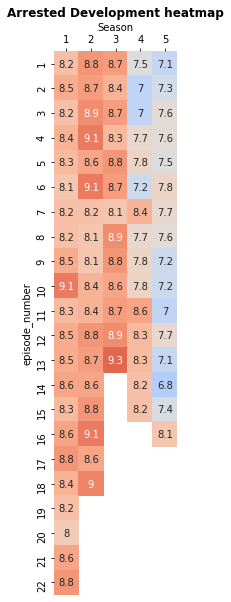

In [4]:
df2 = IMDB('tt0367279', 'Arrested Development', 1, 5)

In [12]:
df2.loc[df2['total_votes'].idxmax()]

Season                                                            1
episode_number                                                    1
title                                                         Pilot
airdate                                         2003-11-02 00:00:00
rating                                                          8.2
total_votes                                                    3015
desc              After his father fails to promote him within t...
weightavg                                                     24723
Name: 0, dtype: object

In [13]:
df2.head()

,Season,episode_number,title,airdate,rating,total_votes,desc,weightavg
0,1,1,Pilot,2003-11-02,8.2,3015,After his father fails to promote him within t...,24723.0
1,1,2,Top Banana,2003-11-09,8.5,2635,Michael suspects that George Sr. is running th...,22397.5
2,1,3,Bringing Up Buster,2003-11-16,8.2,2418,A reluctant Michael takes Buster under his win...,19827.6
3,1,4,Key Decisions,2003-11-23,8.4,2292,Determined to not be upstaged by his actress g...,19252.8
4,1,5,Charity Drive,2003-11-30,8.3,2173,Michael trades in his bicycle for his father's...,18035.9


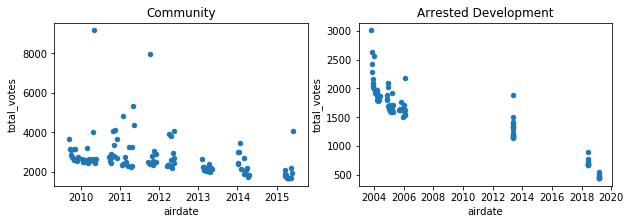

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
ax1 = df1.plot.scatter(x='airdate', y='total_votes', title='Community', ax = ax1)
ax2 = df2.plot.scatter(x='airdate', y='total_votes', title='Arrested Development', ax = ax2)

Analysis for  Community seasons 1 - 3
IMDB code: tt1439629
Median rating:  8.4
Average rating:   8.5
Number of episodes:   71
Weighted average rating:   8.66
Total number of votes:  216,932

Highest rated episode: Modern Warfare , Season 1  episode  23  [ 9.8 ]
Lowest rated episode: Custody Law and Eastern European Diplomacy , Season 2  episode  18  [ 7.4 ]


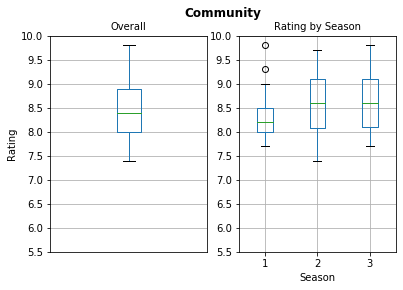

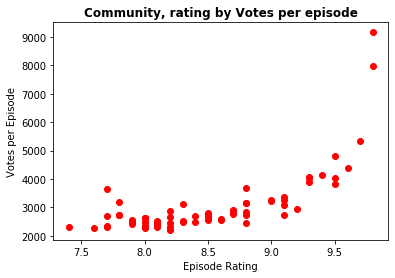

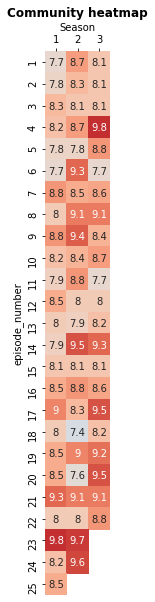

In [26]:
df3 = IMDB('tt1439629', 'Community', 1, 3)

Analysis for  Arrested Development seasons 1 - 3
IMDB code: tt0367279
Median rating:  8.6
Average rating:   8.57
Number of episodes:   53
Weighted average rating:   8.57
Total number of votes:  98,870

Highest rated episode: Development Arrested , Season 3  episode  13  [ 9.3 ]
Lowest rated episode: Whistler's Mother , Season 1  episode  20  [ 8.0 ]


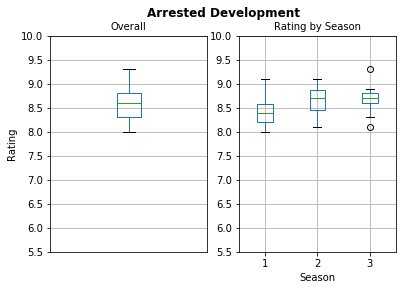

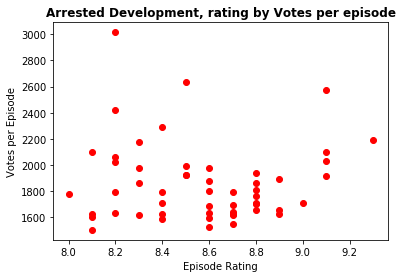

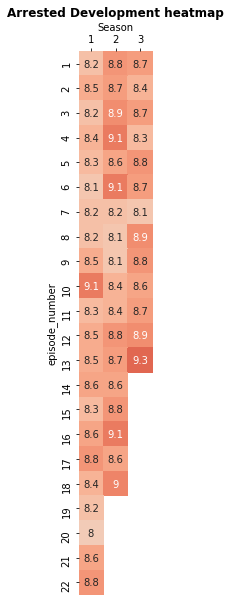

In [6]:
df4 = IMDB('tt0367279', 'Arrested Development', 1, 3)

Analysis for  Supernatural seasons 1 - 14
IMDB code: tt0460681
Median rating:  8.5
Average rating:   8.51
Number of episodes:   307
Weighted average rating:   8.6
Total number of votes:  933,173

Highest rated episode: Changing Channels , Season 5  episode  8  [ 9.7 ]
Lowest rated episode: Bloodlines , Season 9  episode  20  [ 5.8 ]


,Season,episode_number,title,airdate,rating,total_votes,desc,weightavg
0,1,1,Pilot,2005-09-13,8.7,6903,Sam and Dean Winchester were trained by their ...,60056.1
1,1,2,Wendigo,2005-09-20,8.0,5360,Sam and Dean make a stop at Blackwater Ridge a...,42880.0
2,1,3,Dead in the Water,2005-09-27,8.1,4884,"Something, in the lake of a small town, is kil...",39560.4
3,1,4,Phantom Traveler,2005-10-04,8.2,4609,A friend of John's calls Sam and Dean for help...,37793.8
4,1,5,Bloody Mary,2005-10-11,8.5,4755,A game of Bloody Mary unleashes a ghost who li...,40417.5
...,...,...,...,...,...,...,...,...
302,14,16,Don't Go in the Woods,2019-03-21,8.1,1290,Sam and Dean are baffled when they come up aga...,10449.0
303,14,17,Game Night,2019-04-04,7.9,1291,Sam and Dean race to help a friend in need. Me...,10198.9
304,14,18,Absence,2019-04-11,7.8,1295,Sam and Dean continue to worry about the condi...,10101.0
305,14,19,Jack in the Box,2019-04-18,8.0,1282,"Sam, Dean and Castiel investigate a string of ...",10256.0


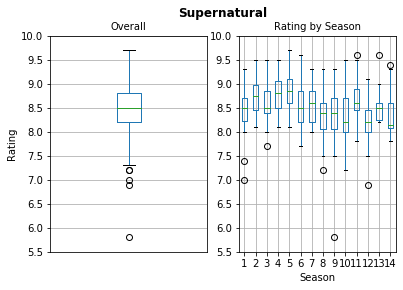

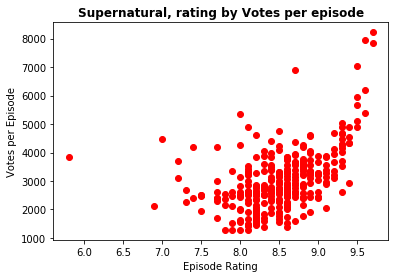

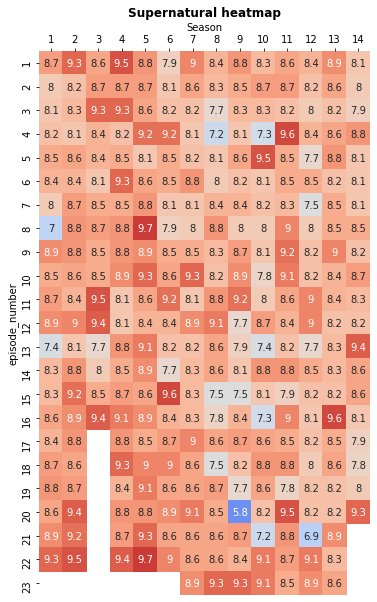

In [7]:
IMDB('tt0460681', 'Supernatural', 1, 14)

Analysis for  Firefly seasons 1 - 1
IMDB code: tt0303461
Median rating:  8.8
Average rating:   8.78
Number of episodes:   14
Weighted average rating:   8.8
Total number of votes:  56,196

Highest rated episode: Out of Gas , Season 1  episode  5  [ 9.4 ]
Lowest rated episode: Safe , Season 1  episode  7  [ 8.3 ]


,Season,episode_number,title,airdate,rating,total_votes,desc,weightavg
0,1,1,The Train Job,2002-09-20,8.5,4219,Mal has second thoughts after discovering that...,35861.5
1,1,2,Bushwhacked,2002-09-27,8.5,3944,Serenity is pulled in by an Alliance cruiser w...,33524.0
2,1,3,Our Mrs. Reynolds,2002-10-04,9.0,4356,A woman claiming to be Mal's wife appears aboa...,39204.0
3,1,4,Jaynestown,2002-10-18,8.8,4087,Mal and the crew of Serenity land to pick up s...,35965.6
4,1,5,Out of Gas,2002-10-25,9.4,4986,"When Serenity's life support system fails, Mal...",46868.4
5,1,6,Shindig,2002-11-01,8.5,3749,In order to secure a job transporting cargo of...,31866.5
6,1,7,Safe,2002-11-08,8.3,3618,Mal must choose which crew members to save whe...,30029.4
7,1,8,Ariel,2002-11-15,9.1,3905,Serenity travels to the core world Ariel and S...,35535.5
8,1,9,War Stories,2002-12-06,8.9,3752,Niska catches up with the Serenity crew.,33392.8
9,1,10,Objects in Space,2002-12-13,9.2,4353,Serenity encounters a ruthlessly professional ...,40047.6


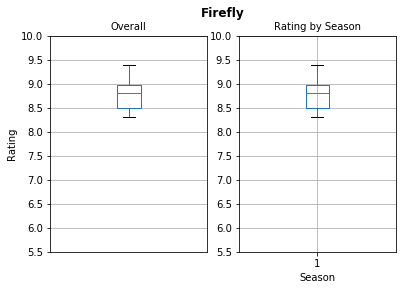

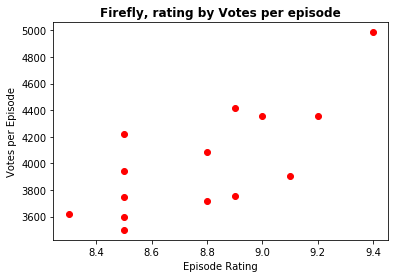

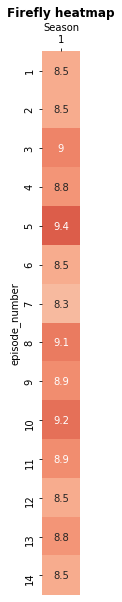

In [8]:
IMDB('tt0303461', 'Firefly', 1, 1)